# Data indexing with Intake

Data indexing is the process of organizing and structuring metadata to facilitate fast and efficient search and retrieval. It involves creating an index, which is a data structure that stores a pointer to the location of the data, allowing for quick access to relevant information. Through our index of data, users can perform searches and get results in a fraction of the time it would take to search through the entire database.

Intake is a Python package that is used for data access and management. It provides a simple interface for loading and exploring data from different data sources in both local and remote storage systems. Intake allows users to define and share data catalogs, which are collections of metadata about the data sources. Intake also provides a mechanism for lazy loading of data, allowing users to work with extremely large datasets (> PB), with index beyond capability of available memory. 

An intake catalog file is a YAML or JSON file that contains a description of a collection of data sources, such as CSV, HDF5, NetCDF, and other formats.  They can include information about the location, format, and any relevant metadata associated with the data sources. Each dataset in the NCI dataset indexing scheme has its own catalog file in YAML format.

Please see the following page for more information on dataset indexing at NCI: https://opus.nci.org.au/x/xgC9D


The following tutorial will demonstrate how to use the NCI intake catalog file for project [iv65: Geoscience Australia Geophysics Reference Data Collection](https://my.nci.org.au/mancini/project/iv65): 

## Start a SparkSession

In [1]:
from intake_spark.base import SparkHolder
h = SparkHolder(True, [('catalog', )], {})
h.setup()
session = h.session[0]
session.conf.set("spark.sql.caseSensitive", "true")

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/05/23 15:59:30 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


## Load the Geophysics dataset catalog file for project iv65.

In [2]:
import intake
catalog = intake.open_catalog("/g/data/dk92/catalog/yml/geophysics-iv65.yml")
df = catalog.mydata.to_spark()

23/05/23 15:59:37 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


## To view the columns in the Spark DataFrame:

In [3]:
print(df.columns)

['attributes', 'dimensions', 'file_md', 'file_type', 'file_uri', 'format', 'variables']


## The attributes contains the following sub-columns:

In [4]:
df.select("attributes").printSchema()

root
 |-- attributes: struct (nullable = true)
 |    |-- Conventions: string (nullable = true)
 |    |-- CreationMethod: string (nullable = true)
 |    |-- CreationTime: string (nullable = true)
 |    |-- GDAL: string (nullable = true)
 |    |-- GDAL_COLORSPACE: string (nullable = true)
 |    |-- GDAL_COMPRESSION_RATE_TARGET: long (nullable = true)
 |    |-- GDAL_VERSION: long (nullable = true)
 |    |-- IntrepidSourceDataset: string (nullable = true)
 |    |-- NCO: string (nullable = true)
 |    |-- cdm_data_type: string (nullable = true)
 |    |-- date_created: string (nullable = true)
 |    |-- date_modified: string (nullable = true)
 |    |-- doi: string (nullable = true)
 |    |-- ecat_id: string (nullable = true)
 |    |-- geospatial_bounds: string (nullable = true)
 |    |-- geospatial_bounds_crs: string (nullable = true)
 |    |-- geospatial_lat_max: double (nullable = true)
 |    |-- geospatial_lat_min: double (nullable = true)
 |    |-- geospatial_lat_resolution: string (null

## To view the geospatial range for some iv65 files:

In [5]:
df.select(["attributes.geospatial_lat_min","attributes.geospatial_lat_max","attributes.geospatial_lon_min","attributes.geospatial_lon_max",]).distinct().show()

+------------------+------------------+------------------+------------------+
|geospatial_lat_min|geospatial_lat_max|geospatial_lon_min|geospatial_lon_max|
+------------------+------------------+------------------+------------------+
|         -33.05293|         -31.97937|          121.4076|          123.0862|
|         -25.11967|         -21.77247|          121.4239|          124.5905|
|         -19.15162|         -17.73014|          142.8654|          144.0373|
|         -34.01112|         -33.62613|          117.4873|          118.0122|
|         -32.47607|         -32.01872|          147.0896|          147.7504|
|         -27.15813|         -25.73017|          116.5526|          118.5208|
|         -29.00332|         -26.97709|          118.4426|          120.0769|
|         -24.10988|         -21.91129|           118.398|           120.998|
|         -28.05786|         -26.94358|          122.9372|          124.5475|
|          -29.0184|         -27.98145|          121.4637|      

## Query based on file_url, survey_id and cdm_data type:

In [6]:
df.select(["file_uri","attributes.survey_id","attributes.cdm_data_type"]).distinct().show(truncate=False)

+-----------------------------------------------------------------------------------------------------------------------------------------------+---------+-------------+
|file_uri                                                                                                                                       |survey_id|cdm_data_type|
+-----------------------------------------------------------------------------------------------------------------------------------------------+---------+-------------+
|/g/data/iv65/Geoscience_Australia_Geophysics_Reference_Data_Collection/airborne_geophysics/GA/line/P908/P908-line-radiometric.nc               |908      |null         |
|/g/data/iv65/Geoscience_Australia_Geophysics_Reference_Data_Collection/airborne_geophysics/GA/line/P614/P614-line-radiometric.nc               |614      |null         |
|/g/data/iv65/Geoscience_Australia_Geophysics_Reference_Data_Collection/airborne_geophysics/GA/line/P636/P636-line-radiometric.nc               |636  

## Filter based on conditional arguments:

In [7]:
### Define a bounding box
lat_min = -27.44
lat_max = -24.04
lon_min = 125.39
lon_max = 131.21

In [8]:
condition=(df.attributes.geospatial_lat_max <= lat_max)\
        &(df.attributes.geospatial_lon_min >= lon_min)\
        &(df.attributes.geospatial_lon_max <= lon_max)\
        &(df.attributes.geospatial_lat_min >= lat_min)

filter_df=df.filter(condition)

print(filter_df.count())

55


In [9]:
filter_df.select(["file_uri"]).show(truncate=False)

+----------------------------------------------------------------------------------------------------------------------------------------------------+
|file_uri                                                                                                                                            |
+----------------------------------------------------------------------------------------------------------------------------------------------------+
|/g/data/iv65/Geoscience_Australia_Geophysics_Reference_Data_Collection/airborne_geophysics/GA/line/P432/P432-line-magnetic.nc                       |
|/g/data/iv65/Geoscience_Australia_Geophysics_Reference_Data_Collection/airborne_geophysics/GA/line/P432/P432-line-magnetic-AWAGS_MAG_2010.nc        |
|/g/data/iv65/Geoscience_Australia_Geophysics_Reference_Data_Collection/airborne_geophysics/WA/line/P1135/P1135-line-magnetic-PartA-AWAGS_MAG_2010.nc|
|/g/data/iv65/Geoscience_Australia_Geophysics_Reference_Data_Collection/airborne_geophysics/WA

## Load the subseted dataset as a list

In [10]:
from pyspark.sql.functions import col

flist=[row['file_uri'] for row in filter_df.select(col('file_uri')).collect()]

In [11]:
print('First five files in flist are:',flist[:5])
print('')
print('Last five file in flist are:',flist[-5:])

First five files in flist are: ['/g/data/iv65/Geoscience_Australia_Geophysics_Reference_Data_Collection/airborne_geophysics/GA/line/P432/P432-line-magnetic.nc', '/g/data/iv65/Geoscience_Australia_Geophysics_Reference_Data_Collection/airborne_geophysics/GA/line/P432/P432-line-magnetic-AWAGS_MAG_2010.nc', '/g/data/iv65/Geoscience_Australia_Geophysics_Reference_Data_Collection/airborne_geophysics/WA/line/P1135/P1135-line-magnetic-PartA-AWAGS_MAG_2010.nc', '/g/data/iv65/Geoscience_Australia_Geophysics_Reference_Data_Collection/airborne_geophysics/WA/line/P1135/P1135-line-magnetic.nc', '/g/data/iv65/Geoscience_Australia_Geophysics_Reference_Data_Collection/airborne_geophysics/WA/line/P1356/P1356-line-magnetic-AWAGS_MAG_2010.nc']

Last five file in flist are: ['/g/data/iv65/Geoscience_Australia_Geophysics_Reference_Data_Collection/ground_gravity/NT/point/P199481/P199481-point-gravity.nc', '/g/data/iv65/Geoscience_Australia_Geophysics_Reference_Data_Collection/ground_gravity/NT/point/P199682/

### Now we can narrow our list of files down further. Let's filter for Western Australian grided data:

In [12]:
flist_WA_grids = [file for file in flist if '/WA/grid' in file]

In [13]:
flist_WA_grids

['/g/data/iv65/Geoscience_Australia_Geophysics_Reference_Data_Collection/airborne_geophysics/WA/grid/P1356/P1356-grid-k_conc.nc',
 '/g/data/iv65/Geoscience_Australia_Geophysics_Reference_Data_Collection/airborne_geophysics/WA/grid/P863/P863-grid-dem_geoid.nc',
 '/g/data/iv65/Geoscience_Australia_Geophysics_Reference_Data_Collection/airborne_geophysics/WA/grid/P1135/P1135-grid-u_conc.nc',
 '/g/data/iv65/Geoscience_Australia_Geophysics_Reference_Data_Collection/airborne_geophysics/WA/grid/P1356/P1356-grid-th_conc.nc',
 '/g/data/iv65/Geoscience_Australia_Geophysics_Reference_Data_Collection/airborne_geophysics/WA/grid/P1356/P1356-grid-u_conc.nc',
 '/g/data/iv65/Geoscience_Australia_Geophysics_Reference_Data_Collection/airborne_geophysics/WA/grid/P1135/P1135-grid-k_conc.nc',
 '/g/data/iv65/Geoscience_Australia_Geophysics_Reference_Data_Collection/airborne_geophysics/WA/grid/P1356/P1356-grid-dose_terr.nc',
 '/g/data/iv65/Geoscience_Australia_Geophysics_Reference_Data_Collection/airborne_geo

## Now we can filter further for files that contain Total Magnetic Intensity (TMI) data:

In [14]:
flist_WA_tmi = sorted([file for file in flist_WA_grids if 'grid-tmi' in file])

In [15]:
flist_WA_tmi

['/g/data/iv65/Geoscience_Australia_Geophysics_Reference_Data_Collection/airborne_geophysics/WA/grid/P1135/P1135-grid-tmi.nc',
 '/g/data/iv65/Geoscience_Australia_Geophysics_Reference_Data_Collection/airborne_geophysics/WA/grid/P1356/P1356-grid-tmi.nc']

## Let's take a look at one of these TMI files:

In [16]:
### Load in required libraries
from netCDF4 import Dataset as NetCDFFile 
import matplotlib.pyplot as plt
import numpy as np

### open first file in our list
nc = NetCDFFile((flist_WA_tmi[-1]))

In [17]:
### print file metadata
print(nc)

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    GDAL: GDAL 3.0.2, released 2019/10/28
    geospatial_lon_resolution: 0.0008333
    geospatial_lat_resolution: 0.0008333
    geospatial_bounds: POLYGON ((127.490125 -26.510804, 127.488391 -26.507889, 127.488573 -25.523738, 127.495106 -25.243737, 127.495407 -25.240903, 127.496758 -25.239929, 128.006056 -25.240518, 129.001341 -25.489752, 129.002372 -25.491060, 129.010186 -26.304541, 129.010691 -26.508035, 129.009688 -26.509364, 129.003532 -26.510482, 127.490125 -26.510804))
    geospatial_lon_min: 127.48858334999998
    geospatial_lat_min: -26.51119915
    geospatial_lon_max: 129.01102245
    geospatial_lat_max: -25.23958335
    nominal_pixel_size_lon_degrees: 0.0008333
    nominal_pixel_size_y_metres: 91.80922406
    nominal_pixel_size_x_metres: 84.01346645
    nominal_pixel_size_lat_degrees: 0.0008333
    geospatial_lat_units: degrees_north
    geospatial_bounds_crs: GEOGCS["GDA94",
    DATUM["Geoc

In [18]:
### look at some of the file variables:

vars = nc.variables.keys()
for item in vars:
    print('Variable: \t', item)
    print('Dimensions: \t', nc[item].dimensions)
    print('Shape:    \t', nc[item].shape, '\n')

Variable: 	 crs
Dimensions: 	 ()
Shape:    	 () 

Variable: 	 lat
Dimensions: 	 ('lat',)
Shape:    	 (1526,) 

Variable: 	 lon
Dimensions: 	 ('lon',)
Shape:    	 (1827,) 

Variable: 	 Band1
Dimensions: 	 ('lat', 'lon')
Shape:    	 (1526, 1827) 



In [19]:
### Load in lat, lon and tmi data

lat = nc.variables['lat'][:]
lon = nc.variables['lon'][:]
tmi = nc.variables['Band1'][:,:]

In [20]:
### Query variable metadata

print(nc['Band1'])

<class 'netCDF4._netCDF4.Variable'>
float32 Band1(lat, lon)
    _FillValue: -inf
    long_name: GDAL Band Number 1
    grid_mapping: crs
    actual_range: [42905.21  59687.645]
unlimited dimensions: 
current shape = (1526, 1827)
filling on


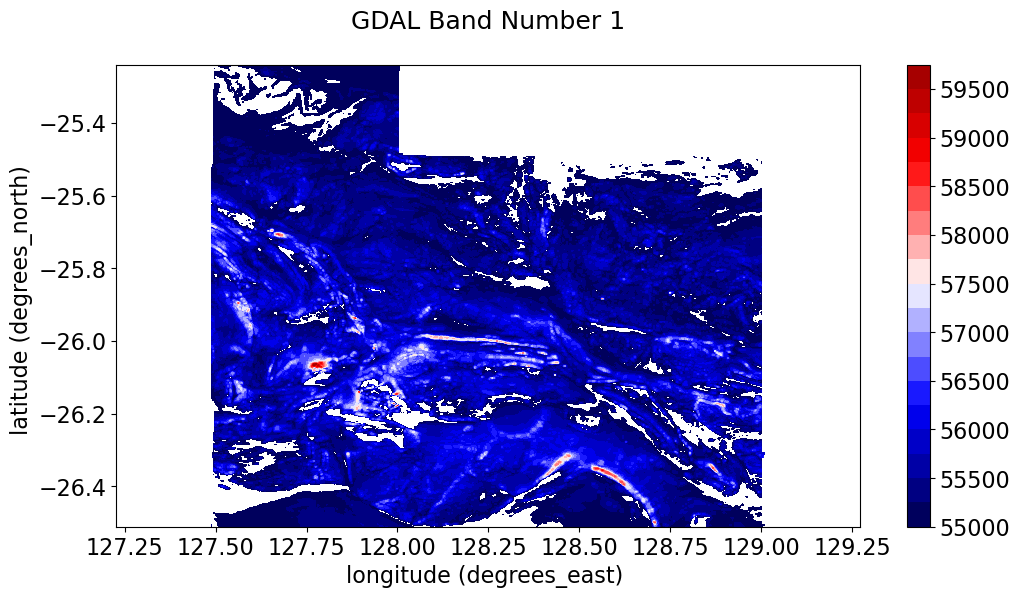

In [21]:
### Plot TMI data as a function of latitude and longitude

# Set figure size
plt.figure(figsize=(12,6))

# Plot data subset with equal axes and colorbar
vmin = 55000
vmax = 60000
levels = np.arange(vmin,vmax,250)
plt.contourf(lon[:], lat[:], tmi[:,:],vmin=vmin,vmax=vmax,levels=levels,cmap=plt.cm.seismic)
plt.axis('equal')
cbar = plt.colorbar()

# Add figure title and labels
# We can make use of the defined variable attributes to do this
plt.title(nc['Band1'].long_name+'\n', fontsize=18)
plt.xlabel(nc['lon'].long_name+' ('+ nc['lon'].units +') ', fontsize=16)
plt.ylabel(nc['lat'].long_name+' ('+ nc['lat'].units +') ', fontsize=16)

# Adjust tick mark size
cbar.ax.tick_params(labelsize=16) 
plt.tick_params(labelsize=16)

## Plotting TMI from multiple files

(-27.0, -25.0)

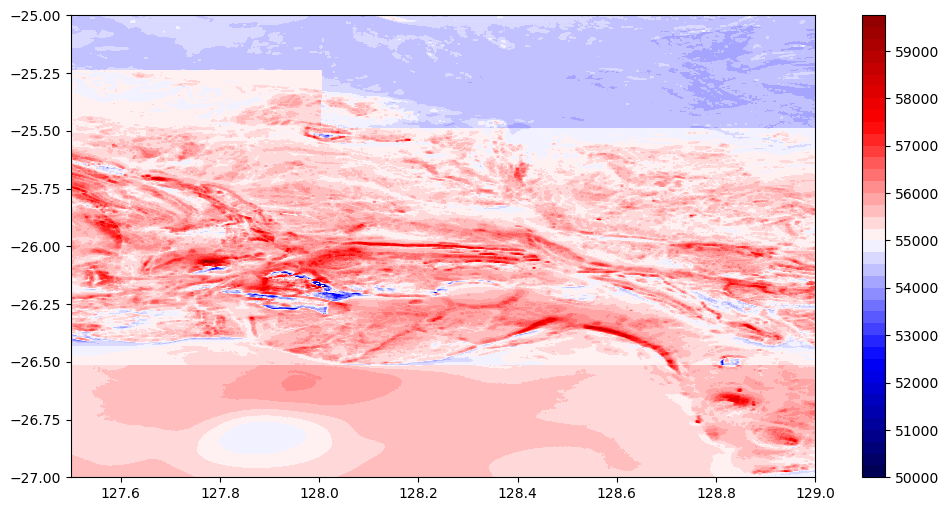

In [22]:
fig = plt.figure(figsize=(12,6))
vmin = 50000
vmax = 60000
levels = np.arange(vmin,vmax,250)

for file in flist_WA_tmi:
    nc = NetCDFFile(file)
    lat = nc.variables['lat'][:]
    lon = nc.variables['lon'][:]
    tmi = nc.variables['Band1'][:,:]
    plt.contourf(lon[:], lat[:], tmi[:,:],vmin=vmin,vmax=vmax,levels=levels, cmap=plt.cm.seismic)

cbar = plt.colorbar()
plt.xlim([127.5,129])
plt.ylim([-27,-25])

## Close Spark session

In [23]:
session.stop()